In [1]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

data_folder_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir, "data_folder"))
sys.path.append(data_folder_path) 

from synth_dim_model import *

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import concurrent.futures
plt.rcParams.update({'font.size': 12})

np.set_printoptions(precision=5, suppress=True, linewidth=100)


<Token var=<ContextVar name='format_options' default={'edgeitems': 3, 'threshold': 1000, 'floatmode': 'maxprec', 'precision': 8, 'suppress': False, 'linewidth': 75, 'nanstr': 'nan', 'infstr': 'inf', 'sign': '-', 'formatter': None, 'legacy': 9223372036854775807, 'override_repr': None} at 0x000002AFC67BD210> at 0x000002AFDED17500>

In [23]:
# -------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# PARAMETERS TO CHANGE

N = 3
M = 2
V = 1
J_V_final = 2
T = 3

# -------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# UNCHANGED PARAMETERS

dt = 0.1
J_V_init = 0
mu_V_init = 10
mu_V_final = 0
num_control_points = 12

print(f"N: {N}")
print(f"M: {M}")
print(f"V: {V}")
print(f"J_V_final: {J_V_final}")
print(f"T: {T}")
    
# -------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# FIRST PASS

print("\nROUGH PASS STARTING")
T_start = 1
results = create_optimal_piecewise_linear_paths(N, M, T_start, dt, V, J_V_init, J_V_final, mu_V_init, mu_V_final, num_control_points)
    
times_dense, J_V_path, mu_V_path, obj_value, opt_params, t_control_opt, J_control_opt, mu_control_opt = results
    
hamiltonians = [construct_rescaled_hamiltonian(N, M, V, mu_V_ratio=mu_V_path[i], J_V_ratio=J_V_path[i]) for i in range(len(times_dense))]
final_results = simulate_hamiltonian_time_evolution(hamiltonians, times_dense)
energies, time_evolved_wavefunctions, state_probabilities, state_overlaps, true_energies, ground_state_manifold_overlaps = final_results
gso = ground_state_manifold_overlaps[-1]
ed = energies[-1] - true_energies[-1,0]
print("ROUGH PASS COMPLETED")
# -------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# SECOND PASS

print("\nREFINED PASS STARTING")
results = create_optimal_piecewise_linear_paths(N, M, T, dt, V, J_V_init, J_V_final, mu_V_init, mu_V_final, num_control_points, initial_guess = opt_params)
    
times_dense, J_V_path, mu_V_path, obj_value, opt_params, t_control_opt, J_control_opt, mu_control_opt = results
    
hamiltonians = [construct_rescaled_hamiltonian(N, M, V, mu_V_ratio=mu_V_path[i], J_V_ratio=J_V_path[i]) for i in range(len(times_dense))]
final_results = simulate_hamiltonian_time_evolution(hamiltonians, times_dense)
energies, time_evolved_wavefunctions, state_probabilities, state_overlaps, true_energies, ground_state_manifold_overlaps = final_results
gso = ground_state_manifold_overlaps[-1]
ed = energies[-1] - true_energies[-1,0]
print("REFINED PASS COMPLETED\n")
    
print(f"GROUND_STATE_OVERLAP: {gso:.6f}")
print(f"ENERGY_DIFFERENCE: {ed:.6f}")

n_int = num_control_points - 2
J_int_opt = opt_params[:n_int]
mu_int_opt = opt_params[n_int:2*n_int]
t_int_opt = opt_params[2*n_int:3*n_int]

J_control_opt = np.concatenate(([J_V_init], J_int_opt, [J_V_final]))
mu_control_opt = np.concatenate(([mu_V_init], mu_int_opt, [mu_V_final]))
t_control_opt = np.concatenate(([0.0], t_int_opt, [T]))

print("\nOPTIMAL_J_VALUES:\n", np.array(J_control_opt))
print("\nOPTIMAL_MU_VALUES:\n", np.array(mu_control_opt))
print("\nOPTIMAL_TIMES:\n", np.array(t_control_opt))


N: 3
M: 2
V: 1
J_V_final: 2
T: 3

ROUGH PASS STARTING
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.016578321021918273
            Iterations: 130
            Function evaluations: 4112
            Gradient evaluations: 130
Success: True
ROUGH PASS COMPLETED

REFINED PASS STARTING
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.014610458419000638
            Iterations: 116
            Function evaluations: 3661
            Gradient evaluations: 116
Success: True
REFINED PASS COMPLETED

GROUND_STATE_OVERLAP: 0.988327
ENERGY_DIFFERENCE: 0.025927

OPTIMAL_J_VALUES:
 [0.      0.1075  0.44569 0.67938 0.91979 1.1705  1.24475 1.61031 1.93706 1.94043 1.99527 2.     ]

OPTIMAL_MU_VALUES:
 [10.       9.57308  8.22908  7.29824  6.33909  5.33926  5.02688  3.3446   1.76757  1.72581  0.2903
  0.     ]

OPTIMAL_TIMES:
 [0.      0.001   0.002   0.00323 0.05805 0.07828 0.34348 0.45255 0.5     1.00755 1.01263 3.  

(0.0, 1.0)

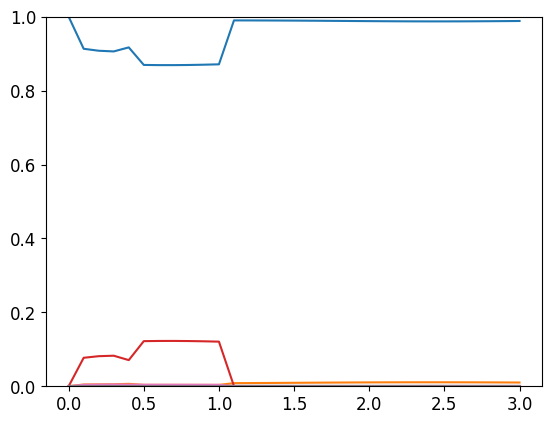

In [24]:
fig, ax = plt.subplots()

for i in range(8):
    ax.plot(times_dense, state_probabilities[:,i])
ax.set_ylim(0,1)

(0.0, 3.0)

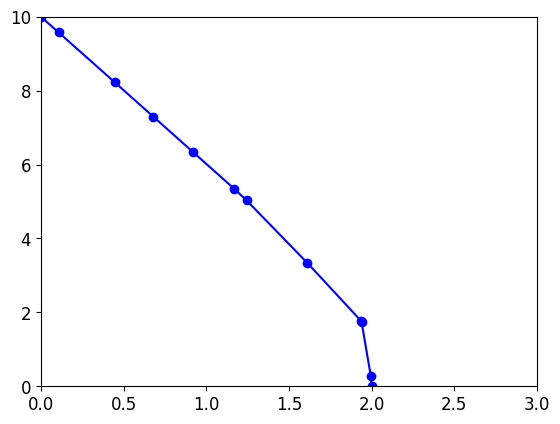

In [25]:
fig, ax = plt.subplots()
ax.plot(J_control_opt, mu_control_opt, marker = "o", color = "b")
ax.set_ylim(0,10)
ax.set_xlim(0,3)

In [3]:
"""N = 3
M = 2
V = 1
dt = 0.1

J_V_init = 0.1
J_V_final = 0.5
mu_V_init = 10
mu_V_final = 0

num_control_points = 12

Ts = np.linspace(0.1,10,25)
ground_state_overlaps = []
energy_differences = []

opt_params = None

for T in Ts:
    opt_params = None
    
    print(f"\nOptimizing for T = {T}")
    
    results = create_optimal_piecewise_linear_paths(
        N, M, T, dt, V,
        J_V_init, J_V_final,
        mu_V_init, mu_V_final,
        num_control_points,
        initial_guess=opt_params
    )
    
    times_dense, J_V_path, mu_V_path, obj_value, opt_params, t_control_opt, J_control_opt, mu_control_opt = results
    
    hamiltonians = [construct_rescaled_hamiltonian(N, M, V, mu_V_ratio=mu_V_path[i], J_V_ratio=J_V_path[i]) for i in range(len(times_dense))]
    final_results = simulate_hamiltonian_time_evolution(hamiltonians, times_dense)
    energies, time_evolved_wavefunctions, state_probabilities, state_overlaps, true_energies, ground_state_manifold_overlaps = final_results
    gso = ground_state_manifold_overlaps[-1]
    ground_state_overlaps.append(gso)
    ed = energies[-1] - true_energies[-1,0]
    energy_differences.append(ed)
    
    print(f"GROUND_STATE_OVERLAP: {gso:.6f}")
    print(f"ENERGY_DIFFERENCE: {ed:.6f}")
    print()
    
print("All finished:")
print(f"Evolution Times: {Ts}")
print(f"Ground State Overlaps = {ground_state_overlaps}")
print(f"Energy Differences = {ground_state_overlaps}")"""

'N = 3\nM = 2\nV = 1\ndt = 0.1\n\nJ_V_init = 0.1\nJ_V_final = 0.5\nmu_V_init = 10\nmu_V_final = 0\n\nnum_control_points = 12\n\nTs = np.linspace(0.1,10,25)\nground_state_overlaps = []\nenergy_differences = []\n\nopt_params = None\n\nfor T in Ts:\n    opt_params = None\n    \n    print(f"\nOptimizing for T = {T}")\n    \n    results = create_optimal_piecewise_linear_paths(\n        N, M, T, dt, V,\n        J_V_init, J_V_final,\n        mu_V_init, mu_V_final,\n        num_control_points,\n        initial_guess=opt_params\n    )\n    \n    times_dense, J_V_path, mu_V_path, obj_value, opt_params, t_control_opt, J_control_opt, mu_control_opt = results\n    \n    hamiltonians = [construct_rescaled_hamiltonian(N, M, V, mu_V_ratio=mu_V_path[i], J_V_ratio=J_V_path[i]) for i in range(len(times_dense))]\n    final_results = simulate_hamiltonian_time_evolution(hamiltonians, times_dense)\n    energies, time_evolved_wavefunctions, state_probabilities, state_overlaps, true_energies, ground_state_mani

In [4]:
"""plt.figure(figsize=(8,5))
plt.plot(Ts, ground_state_overlaps, marker='o', color = "blue")
plt.xlabel('Total Evolution Time $T$')
plt.ylabel('$\langle \psi(T) | P_D | \psi(T) \\rangle$')
plt.title(f'GS Manifold Overlap vs Total Time: $N = {N}$, $M = {M}$, $V = {V}$, $(J/|V|)_f = {J_V_final}$')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(Ts, energy_differences, marker='o', color = "red")
plt.xlabel('Total Evolution Time $T$')
plt.ylabel('$E(T) - E_0$')
plt.title(f'Energy Difference vs Total Time: $N = {N}$, $M = {M}$, $V = {V}$, $(J/|V|)_f = {J_V_final}$')
plt.grid(True)
plt.tight_layout()
plt.show()"""

'plt.figure(figsize=(8,5))\nplt.plot(Ts, ground_state_overlaps, marker=\'o\', color = "blue")\nplt.xlabel(\'Total Evolution Time $T$\')\nplt.ylabel(\'$\\langle \\psi(T) | P_D | \\psi(T) \\rangle$\')\nplt.title(f\'GS Manifold Overlap vs Total Time: $N = {N}$, $M = {M}$, $V = {V}$, $(J/|V|)_f = {J_V_final}$\')\nplt.grid(True)\nplt.tight_layout()\nplt.show()\n\nplt.figure(figsize=(8,5))\nplt.plot(Ts, energy_differences, marker=\'o\', color = "red")\nplt.xlabel(\'Total Evolution Time $T$\')\nplt.ylabel(\'$E(T) - E_0$\')\nplt.title(f\'Energy Difference vs Total Time: $N = {N}$, $M = {M}$, $V = {V}$, $(J/|V|)_f = {J_V_final}$\')\nplt.grid(True)\nplt.tight_layout()\nplt.show()'